In [18]:
%matplotlib inline
import matplotlib
matplotlib.rc('font',family='Century Gothic')
import matplotlib.pyplot as plt
import sys
import numpy as np
from collections import Counter
import fetch_content as fc

# Some input parameteres

In [19]:
Files = (1610, 1809) #first, last file to read

userdatadir = 'data/user_data/%s'
comdir      = userdatadir %'comment'
subdir      = userdatadir %'submission'

moddatadir  = 'data/mod_data/'

# Loading and pre-processing User-data

In [20]:
#Load data
Dicts_com = {}
Dicts_sub = {}
i = Files[0]
while i <= Files[1]:
    filename_com = '%s/%i.dat' %(comdir,i)
    filename_sub = '%s/%i.dat' %(subdir,i)
    try:
        Dicts_com[i] = fc.file2data(filename_com)
        Dicts_sub[i] = fc.file2data(filename_sub)
    except IOError:
        print '%s missing.' %filename
    
    #computing next i
    ij = i/100
    im = i - ij * 100
    
    im = (im + 1) % 12
    if im == 0:
        im = 12
    elif im == 1:
        ij = ij + 1
        
    i = 100 * ij + im 

In [21]:
# extract interesting data
def append2dict(dic, key, value):
    if key in dic.keys():
        if type(value) in [np.ndarray, list, tuple]:
            dic[key].append(np.array(value))
        elif type(value) == dict:
            dic[key].append(value)
        else:
            dic[key] = np.append(dic[key], value)
    else:
        if type(value) in [np.ndarray, list, tuple]:
            dic[key] = [np.array(value)]
        elif type(value) == dict:
            dic[key] = [value]
        else:
            dic[key] = np.array([value])

DataU = {}
for k in np.sort(Dicts_com.keys()):
    append2dict(DataU, 'months', k)
    
    d_com = fc.keynumbers(Dicts_com[k], kind = 'comment')
    append2dict(DataU, 'N_com', d_com['N'])    
    append2dict(DataU, 'length_com', d_com['length'])
    append2dict(DataU, 'percentiles_length_com', d_com['length_percentiles'])
    append2dict(DataU, 'scores_com', d_com['scores'])
    append2dict(DataU, 'sum_scores_com', sum(d_com['scores']))
    append2dict(DataU, 'percentiles_scores_com', d_com['scores_percentiles'])
    append2dict(DataU, 'N_approved_com', d_com['N_approved'])
    
    d_sub = fc.keynumbers(Dicts_sub[k], kind = 'submission')
    append2dict(DataU, 'N_sub', d_sub['N'])
    append2dict(DataU, 'length_sub', d_sub['length'])
    append2dict(DataU, 'percentiles_length_sub', d_sub['length_percentiles'])
    append2dict(DataU, 'scores_sub', d_sub['scores'])
    append2dict(DataU, 'sum_scores_sub', sum(d_sub['scores']))
    append2dict(DataU, 'percentiles_scores_sub', d_sub['scores_percentiles'])
    append2dict(DataU, 'comments_sub', d_sub['comments'])
    append2dict(DataU, 'N_approved_sub', d_sub['N_approved'])
    
    append2dict(DataU, 'un_users', len(set( d_com['users'] + d_sub['users'] )) )
    
    append2dict(DataU, 'contributions_per_user', dict(Counter(d_com['users'] + d_sub['users'])) )
    
NMonths = len(DataU['months'])

#make months labels
Months = sorted(DataU['months'])
MonthsL = []
skipmonth = 3

im_prev = None
for ndx,i in enumerate(Months):
    ij = i/100
    im = i - ij * 100
    if ndx%skipmonth==0:
        monthL = '%02i.%i' %(im,ij)
    else:
        monthL = ''
    MonthsL.append(monthL)
      
    im_prev = im
    
DataU['Months'] = MonthsL

# Loading and pre-processing Mod-data

In [22]:
def readFile(filename):
    #read file
    f = open(filename,'r')
    Mods = []
    Data = []
    i = 0
    for line in f:
        if i == 0:
            Labels = line.strip().strip(',').split(',')
            i = 1
        else:
            cols = line.replace('%','').strip().split(',')
            if cols[0] == 'Total':
                break
            Mods.append(cols[0])
            Data.append(map(int,cols[1:]))
    h,w = np.array(Data).shape
    if h != len(Mods) or w != len(Labels):
        sys.exit("Labels and data don't match.")

    #creating dictionary
    Dict = {}
    for m in xrange(len(Mods)):
        mod = Mods[m]
        Dict[mod] = {}
        for a in xrange(len(Labels)):
            action = Labels[a]
            Dict[mod][action] = Data[m][a]
            
    return Dict

In [23]:
#Load data
DictsM = {}
MonthIDs = []
i = Files[0]
while i <= Files[1]:
    filename = '%s/%i.csv' %(moddatadir,i)
    MonthIDs.append(i)
    try:
        dct = readFile(filename)
        DictsM[i] = dct
    except IOError:
        print '%s missing.' %filename
    
    #computing next i
    ij = i/100
    im = i - ij * 100
    
    im = (im + 1) % 12
    if im == 0:
        im = 12
    elif im == 1:
        ij = ij + 1
        
    i = 100 * ij + im    

data/mod_data//1707.csv missing.
data/mod_data//1708.csv missing.
data/mod_data//1709.csv missing.
data/mod_data//1710.csv missing.
data/mod_data//1711.csv missing.
data/mod_data//1712.csv missing.


In [24]:
#list of bots
Bots = ['lubichsBot','SEO_Nuke','reddit','AutoModerator','javacode']

In [25]:
keyNumbers = [['Total','total mod actions'],
                   ['ban user','banned users'],
                   ['approve post','approved posts'],
                   ['remove post','removed posts'],
                   ['approve comment','approved comments'],
                   ['remove comment','removed comments'],
                   ['spam comment','spammed comments'],
                   ['spam post','spammed posts']]

In [26]:
#fill data in new dict
DataM = {}

for key, _ in keyNumbers:
    numbers = np.zeros(NMonths)
    for i, month in enumerate(MonthIDs):
        if month in DictsM.keys():
            Moderators = DictsM[month].keys()
            number = 0
            for mod in Moderators:
                if mod not in Bots:
                    try:
                        n = DictsM[month][mod][key]
                    except KeyError:
                        n = 0
                    number = number + n
            numbers[i] = number
        else:
            numbers[i] = np.nan
    DataM[key] = numbers
        
DataM['Months'] = DataU['Months']

# Some calculations

In [27]:
#compute additional data
DataM['post removal ratio']     = (DataM['remove post'] + DataM['spam post']) \
                                    /(DataU['N_sub'] + DataM['remove post'] + DataM['spam post'])
DataM['post approval ratio']    = (DataU['N_approved_sub']) \
                                    /(DataU['N_sub'] + DataM['remove post'] + DataM['spam post'])
DataM['comment removal ratio']  = (DataM['remove comment'] + DataM['spam comment']) \
                                    /(DataU['N_com'] + DataM['remove comment'] + DataM['spam comment'])
DataM['comment approval ratio'] = (DataU['N_approved_com']) \
                                    /(DataU['N_com'] + DataM['remove comment'] + DataM['spam comment'])
DataM['ban ratio']              = DataM['ban user']/DataU['un_users']

DataU['total karma']            = DataU['sum_scores_sub'] + DataU['sum_scores_com']
DataU['total karma per user']   = DataU['total karma']/map(float, DataU['un_users'])

In [28]:
DataU['total karma per user']

array([123.95228967, 144.49623926, 135.49828403, 153.02147389,
       148.85153976, 150.67972973, 147.88994469, 161.97470446,
       174.73500146, 187.08675325, 177.89040529, 192.35359446,
       183.49106838, 185.62078451, 176.56485492, 179.23624471,
       174.44131817, 174.46746285, 166.82056683, 164.27174399,
       159.47070741, 151.43881366, 151.55698088, 156.6413513 ])

In [29]:
### build post-time - score histogram - this was used in July 2018
# get seconds after Monday 00:00
import datetime
from fetch_content import _str2timestamp_

def get_seconds_after_monday_midnight(timestr):
    t = _str2timestamp_(timestr)
    d = datetime.datetime.fromtimestamp(t)
    d_monday = d.replace(hour=0, minute=0, second=0, microsecond=0) - datetime.timedelta(days=d.weekday())
    return (d - d_monday).total_seconds()

# build score and post-time arrays
Scores = []
PostTimes = []
for k in Dicts_com.keys():
    for c in Dicts_com[k]+Dicts_sub[k]:
        Scores.append(c['score'])
        PostTimes.append(get_seconds_after_monday_midnight(c['time']))
DataU['karma post times'] = np.array(PostTimes)
DataU['karma scores'] = np.array(Scores)
DataU['karma ticks'] = np.arange(7) * 3600*24
DataU['karma tick labels'] = ['Mo', 'Tu', 'We', 'Th', 'Fr', 'Sa', 'So']

def plot_special(ax):
    X = ax.hist(DataU['karma post times'], weights=DataU['karma scores'], bins=24*7/2,
                 color='#7f2a99', alpha=alpha_areas,
                     label='best time to post: We, 12:00')
    ax.legend(loc='best', ncol=2, frameon=False, fontsize=9)
    ax.set_xticks(DataU['karma ticks'])
    ax.set_xticklabels(DataU['karma tick labels'])
    ax.set_xlim(0,3600*7*24)
    ax.set_ylim(0,9e5)
    ax.spines['left'].set_visible(False)
    ax.tick_params(right=False)
    ax.set_yticks([])
    ax.set_title('karma distribution by time of the week')  

In [30]:
### build karma histogram - this was used in September 2018
def plot_special(ax):
    range = (-500, 3000)
    n1, bins = np.histogram(np.concatenate(DataU['scores_sub']), density=False, bins=40, range=range)
    n2, bins = np.histogram(np.concatenate(DataU['scores_com']), density=False, bins=40, range=range)
    
    from scipy.interpolate import interp1d
    fn1 = interp1d(bins[0:-1], n1, kind='previous', fill_value=0, bounds_error=False)
    fn2 = interp1d(bins[0:-1], n2, kind='previous', fill_value=0, bounds_error=False)
    
    x = np.linspace(range[0],range[1],1000)
    ax.fill_between(x, fn1(x), color='orange', alpha=0.1, lw=0)
    ax.plot(x[0:-30], fn1(x)[0:-30], label='submissions', color='orange', alpha=alpha_lines, lw=linewidth)
    
    ax.fill_between(x, fn2(x), color='#7f2a99', alpha=0.1, lw=0)
    ax.plot(x, fn2(x), label='comments', color='#7f2a99', alpha=alpha_lines, lw=linewidth)
    
    ax.set_yscale("log")
    ax.set_xlim(range)
    ax.set_ylim(1,1e7)
    ax.legend()
    ax.set_xlabel('karma')
    ax.set_title('karma-histogram')
    
X = np.concatenate(DataU['scores_sub'])
print 'median submissions: %i' %np.median(X)

X = np.concatenate(DataU['scores_com'])
print 'median comments: %i' %np.median(X)

median submissions: 12
median comments: 3


# Plotting

In [31]:
def plotLine(ax, X, Y, Holes, args={}):
    h_prev = 0
    for h in Holes:
        ax.plot(X[h_prev:h],Y[h_prev:h],**args)
        h_prev = h
    ax.plot(X[h_prev:],Y[h_prev:],**args)

In [32]:
def add_twiny(axx):
    a = axx.twinx()
    axes.append(a)
    return a

In [33]:
def plot_line_and_points(ax, X, Y, lineargs={}, pointargs={}):
    plotLine(ax, X, Y, [], lineargs)
    ax.scatter(X, Y, **pointargs)

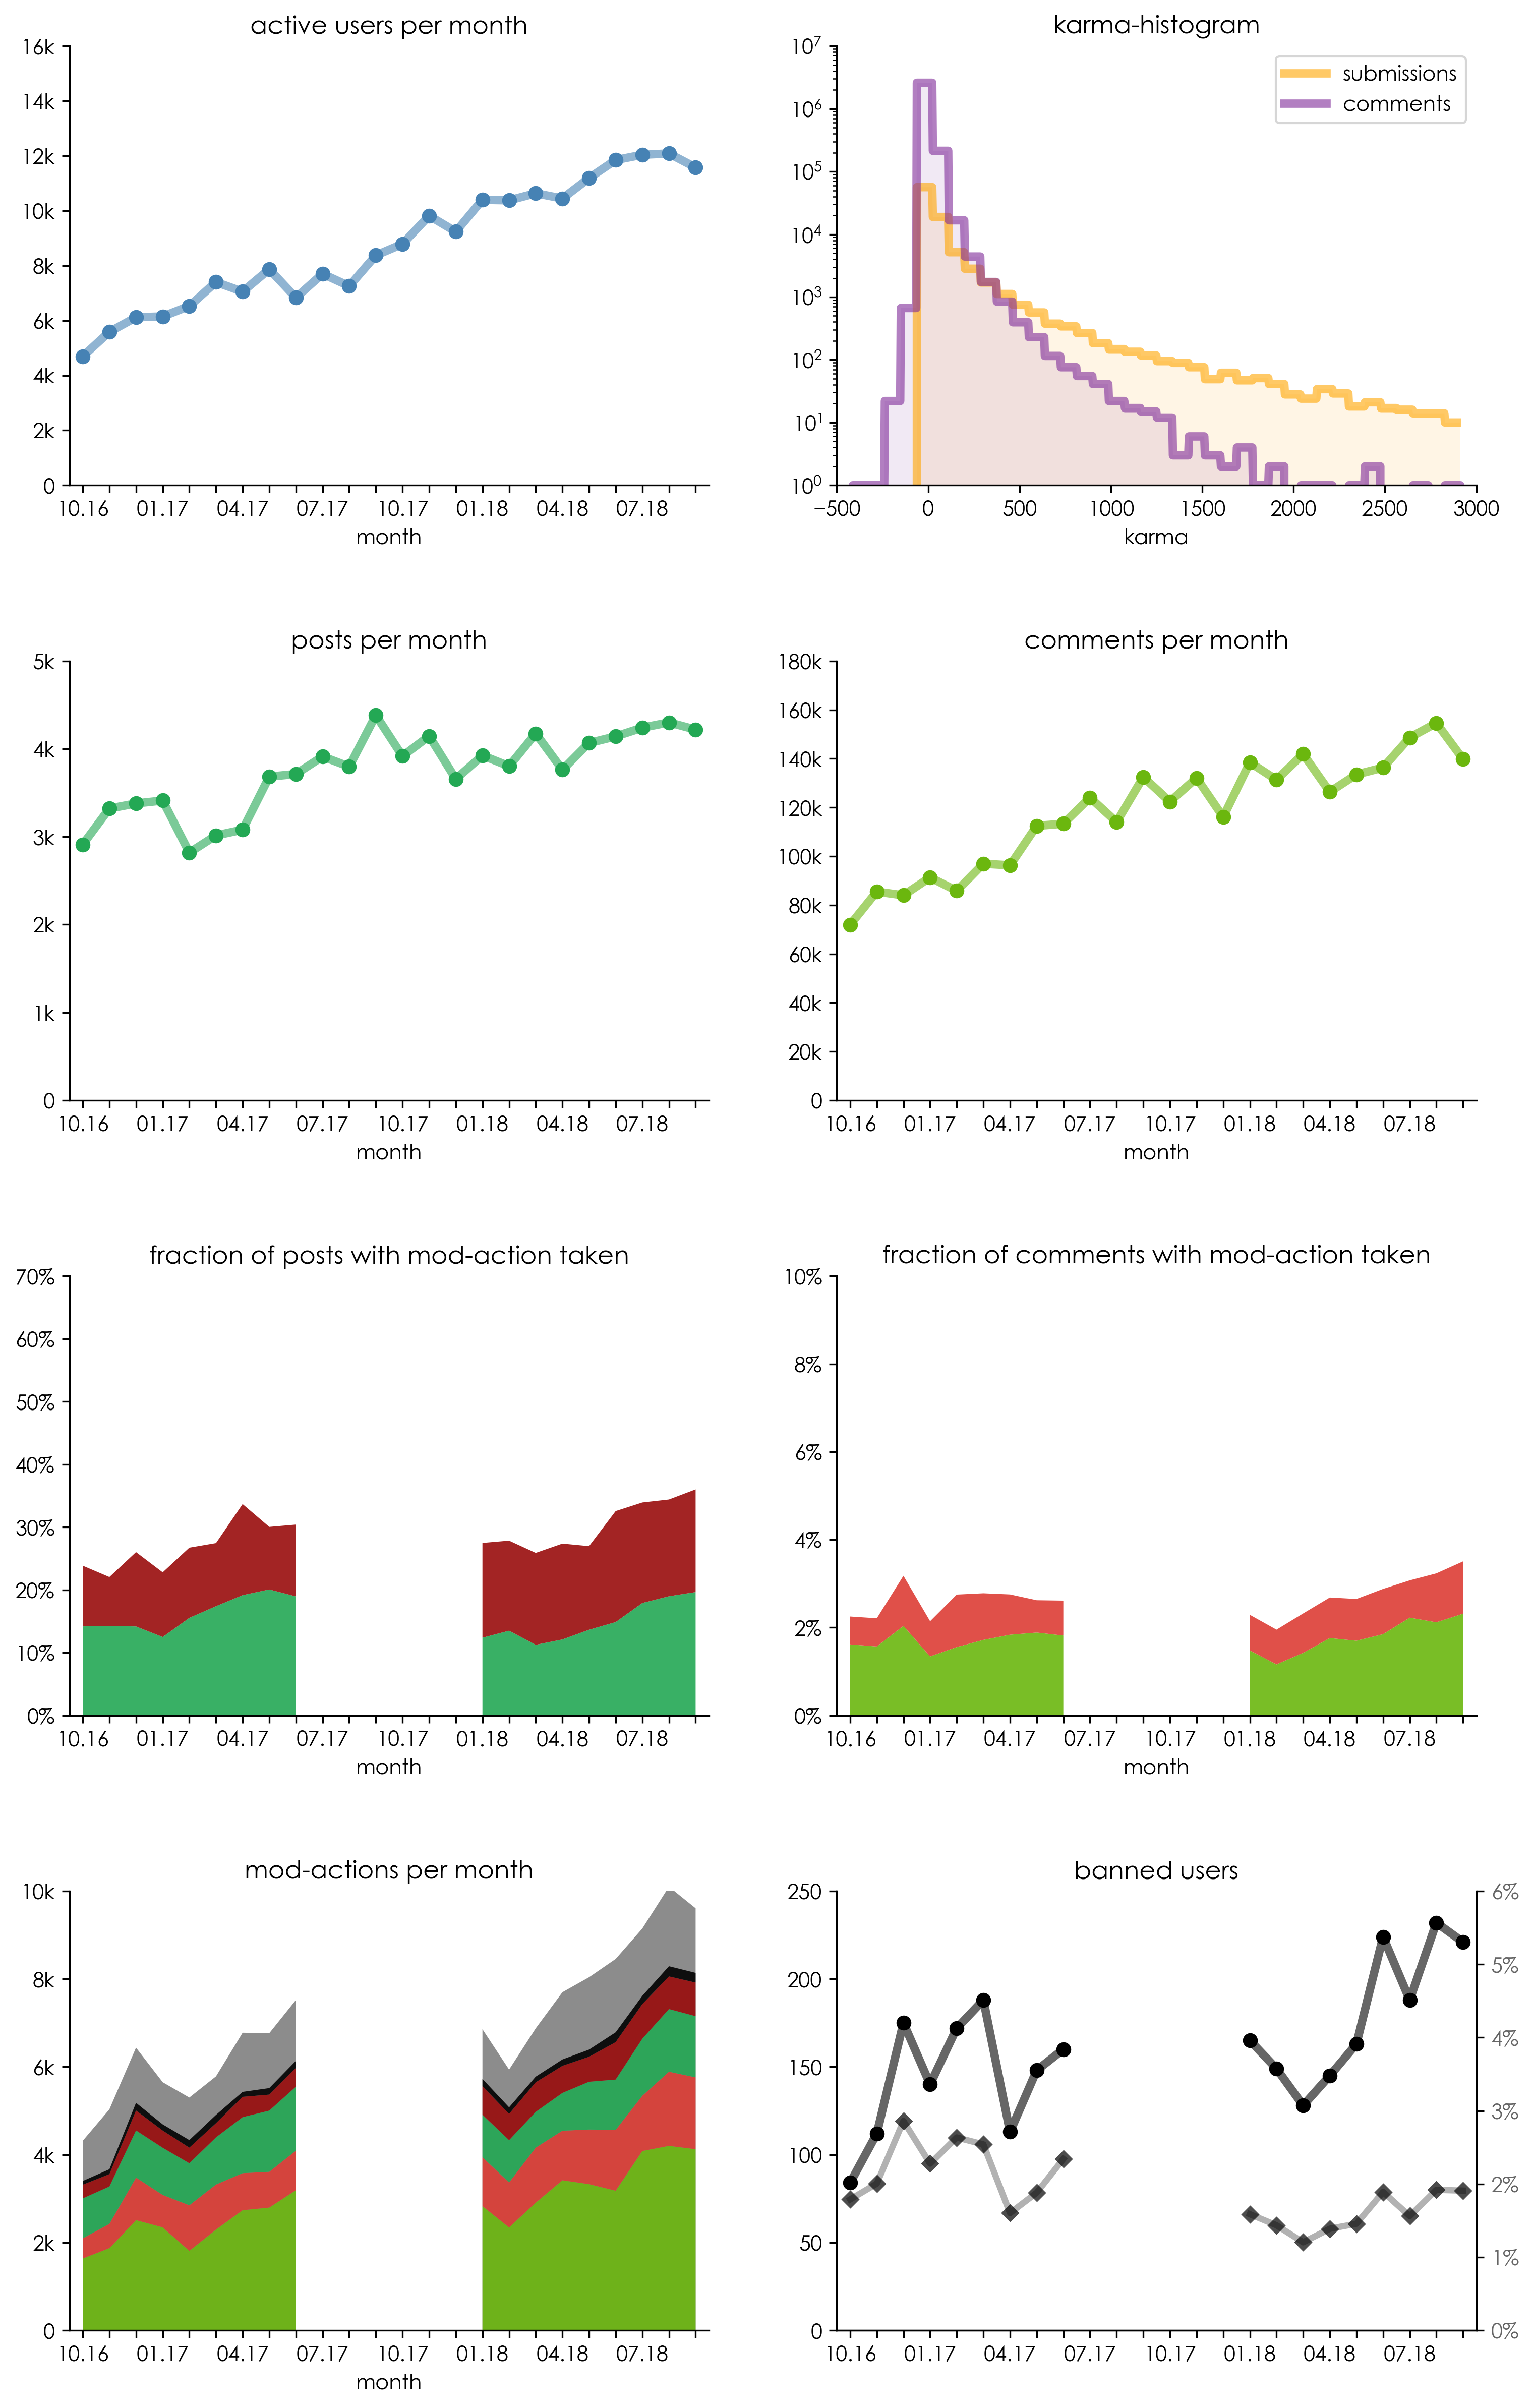

In [35]:
#plotting lines
f, ax = plt.subplots(4,2, figsize=(12, 20), dpi=300, facecolor='white', frameon=False)
axes = list(ax.flatten())
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.4)

MonthsI      = np.arange(NMonths)
width        = 0.5
alpha_points = 1.0
alpha_lines  = 0.6
alpha_areas  = 0.9
linewidth    = 4
pointwidth   = 50

ax_abbreviate_k    = []  # abbreviate 1000 by k in labels
ax_has_right_spine = []
ax_in_percent      = []
ax_x_label_month   = []

### Unique users       
plot_line_and_points(ax[0][0], MonthsI, DataU['un_users'], 
                     lineargs={'color': 'steelblue', 'linewidth': linewidth, 'alpha': alpha_lines},
                     pointargs={'s': pointwidth, 'color': 'steelblue', 'alpha': alpha_points, 'lw': 0})
ax[0][0].set_ylim(0,16000)
ax[0][0].set_title('active users per month')
ax_abbreviate_k.append(ax[0][0])
ax_x_label_month.append(ax[0][0])

### monthly special
plot_special(ax[0][1])


#### Total amount of karma
#plot_line_and_points(ax[0][1], MonthsI, DataU['total karma'], 
#                     lineargs={'color': '#ff5b1e', 'linewidth': linewidth, 'alpha': alpha_lines},
#                     pointargs={'s': pointwidth, 'color': '#ff5b1e', 'alpha': alpha_points, 'lw': 0})
#ax[0][1].set_ylim(0,2250000)
#ax[0][1].set_title('karma per month')
#ax_abbreviate_k.append(ax[0][1])
### karma per active user
#ax_01 = add_twiny(ax[0][1])
#plot_line_and_points(ax_01, MonthsI, DataU['total karma per user'], 
#                     lineargs={'color': '#FF8b60', 'linewidth': linewidth-1, 'alpha': alpha_lines-0.2},
#                     pointargs={'s': pointwidth-12, 'color': '#FF8b60', 'alpha': alpha_points-0.2, 'lw': 0,
#                               'marker': 'D'})
#ax_01.set_ylim(0, 250)
#ax_has_right_spine.append(ax_01)
#ax_x_label_month.append(ax_01)

### Number of posts
plot_line_and_points(ax[1][0], MonthsI, DataU['N_sub'], 
                     lineargs={'color': '#23a854', 'linewidth': linewidth, 'alpha': alpha_lines},
                     pointargs={'s': pointwidth, 'color': '#23a854', 'alpha': alpha_points, 'lw': 0})
ax[1][0].set_ylim(0,5000)
ax[1][0].set_title('posts per month')
ax_abbreviate_k.append(ax[1][0])
ax_x_label_month.append(ax[1][0])

## Fraction of removed posts
#ax_10 = add_twiny(ax[1][0])
#plot_line_and_points(ax_10, MonthsI, 100*DataM['post removal ratio'], 
#                     lineargs={'color': '#990c0c', 'linewidth': linewidth-1, 'alpha': alpha_lines-0.3,
#                              'label': 'fraction removed by moderators (in %)'},
#                     pointargs={'s': pointwidth-12, 'color': '#990c0c', 'alpha': alpha_points-0.3, 'lw': 0,
#                               'marker': 'D'})
#ax_10.set_ylim(0, 40)
#ax_has_right_spine.append(ax_10)
#ax_in_percent.append(ax_10)
#ax_x_label_month.append(ax_10)

### Number of comments
plot_line_and_points(ax[1][1], MonthsI, DataU['N_com'], 
                     lineargs={'color': '#6bb70e', 'linewidth': linewidth, 'alpha': alpha_lines},
                     pointargs={'s': pointwidth, 'color': '#6bb70e', 'alpha': alpha_points, 'lw': 0})
ax[1][1].set_ylim(0,180000)
ax[1][1].set_title('comments per month')
ax_abbreviate_k.append(ax[1][1])
ax_x_label_month.append(ax[1][1])

## Fraction of removed comments
#ax_11 = add_twiny(ax[1][1])
#plot_line_and_points(ax_11, MonthsI, 100*DataM['comment removal ratio'], 
#                     lineargs={'color': '#dd3d35', 'linewidth': linewidth-1, 'alpha': alpha_lines-0.3},
#                     pointargs={'s': pointwidth-12, 'color': '#dd3d35', 'alpha': alpha_points-0.3, 'lw': 0,
#                               'marker': 'D'})
#ax_11.set_ylim(0, 3)
#ax_has_right_spine.append(ax_11)
#ax_in_percent.append(ax_11)
#ax_x_label_month.append(ax_11)

### Post moderation ratio
ax[2][0].stackplot(MonthsI, 
                   100*DataM['post approval ratio'],
                   100*DataM['post removal ratio'],
                   labels=['approved',
                          'removed'],
                  colors=['#23a854',
                         '#990c0c'],
                  alpha=alpha_areas)
ax[2][0].set_ylim(0,70)
ax[2][0].set_title('fraction of posts with mod-action taken')
ax_in_percent.append(ax[2][0])
ax_x_label_month.append(ax[2][0])

### Comments moderation ratio
ax[2][1].stackplot(MonthsI, 
                   100*DataM['comment approval ratio'],
                   100*DataM['comment removal ratio'],
                   labels=['approved',
                          'removed'],
                  colors=['#6bb70e',
                         '#dd3d35'],
                  alpha=alpha_areas)
ax[2][1].set_ylim(0,10)
ax[2][1].set_title('fraction of comments with mod-action taken')
ax_in_percent.append(ax[2][1])
ax_x_label_month.append(ax[2][1])

### Total Mod actions
ax[3][0].stackplot(MonthsI, DataM['Total'], labels=['other'], colors=['grey'], alpha=alpha_areas)
ax[3][0].stackplot(MonthsI, 
                   DataM['approve comment'],
                   DataM['remove comment'],
                   DataM['approve post'],
                   DataM['remove post'],
                   DataM['ban user'],
                   labels=['approve comment',
                          'remove comment',
                          'approve post',
                          'remove post',
                          'ban user'],
                  colors=['#6bb70e',  # approve comment
                         '#dd3d35',   # remove comment
                         '#23a854',   # approve post
                         '#990c0c',   # remove post
                         'black'],    # ban user
                  alpha=alpha_areas)
#ax[3][0].legend(loc=2, ncol=2, frameon=False, fontsize=9)
ax[3][0].set_ylim(0,10000)
ax[3][0].set_title('mod-actions per month')
ax_abbreviate_k.append(ax[3][0])
ax_x_label_month.append(ax[3][0])

### Number of banned users
plot_line_and_points(ax[3][1], MonthsI, DataM['ban user'], 
                     lineargs={'color': 'black', 'linewidth': linewidth, 'alpha': alpha_lines},
                     pointargs={'s': pointwidth, 'color': 'black', 'alpha': alpha_points, 'lw': 0})
ax[3][1].set_ylim(0,250)
ax[3][1].set_title('banned users')
## Fraction of banned users
ax_31 = add_twiny(ax[3][1])
plot_line_and_points(ax_31, MonthsI, 100*DataM['ban ratio'], 
                     lineargs={'color': 'black', 'linewidth': linewidth-1, 'alpha': alpha_lines-0.3},
                     pointargs={'s': pointwidth-12, 'color': 'black', 'alpha': alpha_points-0.3, 'lw': 0,
                               'marker': 'D', 'label': 'fraction of active users'})
#ax_31.legend(loc='best', ncol=2, frameon=False, fontsize=9)
ax_31.set_ylim(0, 6)
ax_has_right_spine.append(ax_31)
ax_in_percent.append(ax_31)
ax_x_label_month.append(ax_31)

# draw canvas so that tick labels are set
f.canvas.draw()

for a in axes:
    
    # set x ticks and labels
    if a in ax_x_label_month:
        a.set_xlim(-width,NMonths-width)
        a.set_xticks(MonthsI)
        a.set_xticklabels(DataU['Months'])            
        a.set_xlabel('month')

    # remove spines
    if a not in ax_has_right_spine:
        a.spines['right'].set_visible(False)
        a.tick_params(right=False)
    else: # if right spine is there, reduce alpha value
        a.spines['right'].set_alpha(1)
        a.yaxis.label.set_alpha(1)
        a.set_yticklabels(a.get_yticklabels(), alpha=0.6)  
        
    a.tick_params(top=False)
    a.spines['top'].set_visible(False)
    
    # change y-tick labels to k-notation
    if a in ax_abbreviate_k:
        labels = []
        for l in a.get_yticklabels():
            v = int(l.get_position()[1])
            if v >= 1e6:
                labels.append('%4.2fM' %(v/1.0e6))
            elif v >= 1000:
                labels.append('%ik' %(v/1000))

            else:
                labels.append(l.get_text())
        a.set_yticklabels(labels)
        
    # change y-tick labels to append %
    if a in ax_in_percent:
        labels = []
        for l in a.get_yticklabels():
            v = l.get_text()
            labels.append('%s%%' %v)
        a.set_yticklabels(labels)    
                    
plt.savefig('stat_raw.svg',bbox_inches='tight',dpi=500)